>[Сравнение тарифов мобильного оператора](#scrollTo=FH4tBijxGfNF)

>>[Общая информация](#scrollTo=duvjDaN3GfNH)

>>[Предобработка данных](#scrollTo=CB85_sLsGfNN)

>>>[Расчет ежемесячной выручки](#scrollTo=eH9WaNSa-972)

>>[Исследовательский анализ данных](#scrollTo=71axh75nGfNQ)

>>>[Анализ звонков](#scrollTo=s6hwmzeX-NDd)

>>>[Анализ cообщений](#scrollTo=IUTi0Swz-SXS)

>>>[Анализ интернет-трафика](#scrollTo=4Y3jLDj9_U_V)

>>>[Анализ выручки на пользователя](#scrollTo=Ip6g5eYiWv7e)

>>[Проверка гипотез](#scrollTo=YCzIfHYRGfNU)

>>[Вывод](#scrollTo=EHkZrnD_v9Dz)



# Сравнение тарифов мобильного оператора

В нашем распоряжении данные 500 пользователей мобильного оператора «Мегалайна»: за 2018-й год по двум тарифам - «Ультра» и «Смарт»  - количество звонков и сообщений.

**Цель исследования** - выбор тарифа, приносящего больший доход

**Оцениваемые параметры:**

 * количество сделанных звонков разговора для каждого пользователя
 * количество израсходованных минут разговора для каждого пользователя
 * количество отправленных сообщений для каждого пользователя
 * количество потраченных мегабайт для каждого пользователя
 * помесячная выручки 

**План исследования:**

 * оценка различий в поведении пользователей в зависимости от тарифов
 * расчет помесячной выручки 
 * проверка гипотез
  * средняя выручка с пользователей тарифов «Ультра» и «Смарт» различается
  * средняя выручка с пользователей из Москвы отличается от выручки с пользователей других регионов



In [4]:
# загрузим библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st


## Общая информация

In [3]:
# загрузим данные
calls = pd.read_csv('/datasets/calls.csv')
sessions = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')


In [5]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [6]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице `calls` содержится информация о звонках  
Согласно документации  к данным  
 * `id` — уникальный номер звонка
 * `call_date` — дата звонка
 * `duration` — длительность звонка в минутах
 * `user_id` — идентификатор пользователя, сделавшего звонок

`call_date` небходимо преобразовать в формат дат, остальное верно



Посмотрим как распределяются данные с продолжительностью звонков

In [7]:
from importlib import reload
plt=reload(plt)

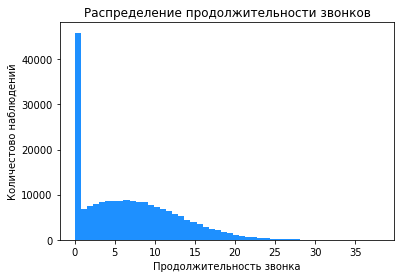

In [8]:
calls['duration'].hist(bins = 50, color='dodgerblue', grid = False)
plt.xlabel('Продолжительность звонка')
plt.ylabel('Количестово наблюдений')
plt.title('Распределение продолжительности звонков');

Большое количество звонков с продолжительностью ноль минут. Возможно, это неотвеченные звонки.  
Посмотрим на распределение звонков с продолжительностью более минуты:

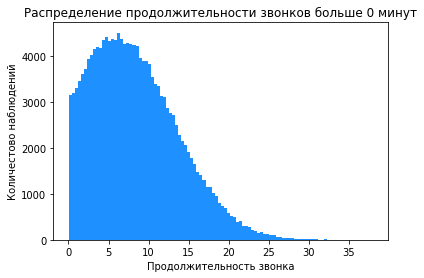

In [9]:
calls[calls['duration']>0]['duration'].hist(bins = 100, color='dodgerblue', grid = False)
plt.xlabel('Продолжительность звонка')
plt.ylabel('Количестово наблюдений')
plt.title('Распределение продолжительности звонков больше 0 минут');


Большинство пользователей совершает звонки длительностью  ~ 5 минут.  
С увеличением продолжительности времени звонка количество наблюдений уменьшается  
Распределение нормальное, положительная ассиметрия

In [10]:
sessions.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [11]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В таблице `sessions` содержится информация об интернет-сессиях:  
Согласно документации  к данным  
 * `id` — уникальный номер звонка
 * `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
 * `session_date` — дата интернет-сессии
 * `user_id` — идентификатор пользователя

`session_date` небходимо преобразовать в формат дат, остальное верно

Посмотрим как распределяются данные для столбца с количеством потраченных мегабайт.

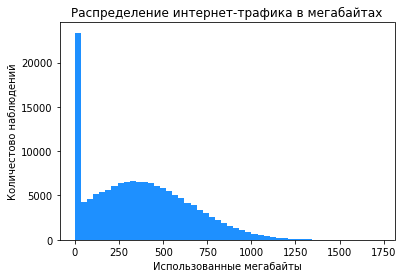

In [12]:
sessions['mb_used'].hist(bins = 50, color='dodgerblue', grid = False)
plt.xlabel('Использованные мегабайты')
plt.ylabel('Количестово наблюдений')
plt.title('Распределение интернет-трафика в мегабайтах');

Также видим, что много наблюдений с нулевым объемом мегабайт.  
Странно, но может быть фиксируется какждый день, даже если юзер не пользовался мобильным интернетом.  
Посмотрим, распределение со значениями потраченныъ мегабайт больше нуля

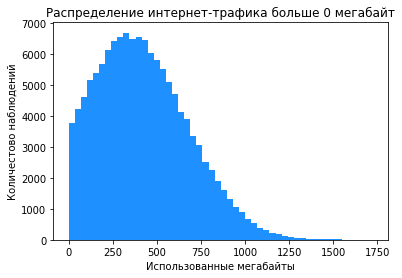

In [13]:
sessions[sessions['mb_used']>0]['mb_used'].hist(bins = 50, color='dodgerblue', grid = False)
plt.xlabel('Использованные мегабайты')
plt.ylabel('Количестово наблюдений')
plt.title('Распределение интернет-трафика больше 0 мегабайт');

Большинство пользователей использует трафика 250-400 мб, с увеличением объема трафика количество наблюдений уменьшается  
Распределение нормальное, положительная ассиметрия

In [14]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [15]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В таблице `messages` содержится информация о сообщениях:
 * `id` — уникальный номер звонка
 * `message_date` — дата сообщения
 * `user_id` — идентификатор пользователя, отправившего сообщение

`message_date` небходимо преобразовать в формат дат, остальное верно

Данные о тарифах:

In [16]:
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [17]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


 * `tariff_name` — название тарифа
 * `rub_monthly_fee` — ежемесячная абонентская плата в рублях
 * `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
 * `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
 * `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
 * `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
 * `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
 * `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [18]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [19]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Таблица `users` — информация о пользователях:
 * `user_id` — уникальный идентификатор пользователя
 * `first_name` — имя пользователя
 * `last_name` — фамилия пользователя
 * `age` — возраст пользователя (годы)
 * `reg_date` — дата подключения тарифа (день, месяц, год)
 * `churn_date` — дата прекращения пользования тарифом (если значение пропущено, значит, тариф ещё действовал на момент выгрузки данных)
 * `city` — город проживания пользователя
 * `tarif` — название тарифного плана

`reg_date`, `churn_date` небходимо преобразовать в формат дат, остальное верно 

## Предобработка данных

Приведем столбцы к формату дат с помощью метода `to_datetime()`

- `reg_date` из таблицы `users`
- `churn_date` из таблицы `users`
- `call_date` из таблицы `calls`
- `message_date` из таблицы `messages`
- `session_date` из таблицы `sessions`


In [20]:
# обработка столбца reg_date
users['reg_date'] = pd.to_datetime(users['reg_date'],format='%Y-%m-%d')
# обработка столбца churn_date
users['churn_date'] = pd.to_datetime(users['churn_date'],format='%Y-%m-%d')
# обработка столбца call_date
calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y-%m-%d')
# обработка столбца message_date
messages['message_date'] = pd.to_datetime(messages['message_date'],format='%Y-%m-%d')
# обработка столбца session_date
sessions['session_date'] = pd.to_datetime(sessions['session_date'], format='%Y-%m-%d')

В столбце `duration` датафрейма `calls` значения дробные. Округлим значения столбца `duration` вверх, тк для оплаты учитывается полная минута и приведем столбец `duration` к типу `int`.

In [21]:


# округление значений столбца duration с помощью np.ceil() и приведение типа к int
calls['duration'] = np.ceil(calls['duration']).astype (int)

Удалим столбец `Unnamed: 0` из датафрейма `sessions`. Столбец с таким названием возникает, когда данные сохраняют с указанием индекса (`df.to_csv(..., index=column)`). Он нам не понадобится.

In [22]:
sessions.drop(columns = ['Unnamed: 0'],axis = 1, inplace=True)

Создадим столбец `month` в датафрейме `calls` с номером месяца из столбца `call_date`.

In [23]:
calls['month'] = calls['call_date'].dt.month

Создадим столбец `month` в датафрейме `messages` с номером месяца из столбца `message_date`.

In [24]:
messages['month'] = messages['message_date'].dt.month

Создадим столбец `month` в датафрейме `sessions` с номером месяца из столбца `session_date`.

In [25]:
sessions['month'] = sessions['session_date'].dt.month

Посчитаем количество сделанных звонков разговора для каждого пользователя по месяцам.

In [26]:
# подсчёт количества звонков для каждого пользователя по месяцам
calls_per_month = calls.groupby(['user_id','month']).agg(calls=('duration', 'count'))

In [27]:
# вывод 30 первых строк на экран
calls_per_month.head(30)

calls
user_id month       
1000    5         22
        6         43
        7         47
        8         52
        9         58
        10        57
        11        43
        12        46
1001    11        59
        12        63
1002    6         15
        7         26
        8         42
        9         36
        10        33
        11        32
        12        33
1003    8         55
        9        134
        10       108
        11       115
        12       108
1004    5          9
        6         31
        7         22
        8         19
        9         26
        10        29
        11        19
        12        21

Посчитаем количество израсходованных минут разговора для каждого пользователя по месяцам и сохраните в переменную `minutes_per_month`.

In [28]:
# подсчёт израсходованных минут для каждого пользователя по месяцам
minutes_per_month = calls.groupby(['user_id','month']).agg(minutes=('duration', 'sum'))

In [29]:
# вывод первых 30 строк на экран
minutes_per_month.head(30)

minutes
user_id month         
1000    5          159
        6          172
        7          340
        8          408
        9          466
        10         350
        11         338
        12         333
1001    11         430
        12         414
1002    6          117
        7          214
        8          289
        9          206
        10         212
        11         243
        12         236
1003    8          380
        9          961
        10         855
        11         824
        12         802
1004    5           35
        6          171
        7          135
        8          137
        9          117
        10         145
        11         117
        12         130

Посчитаем количество отправленных сообщений по месяцам для каждого пользователя и сохраните в переменную `messages_per_month`.

In [30]:
# подсчёт количества отправленных сообщений для каждого пользователя по месяцам
messages_per_month = messages.groupby(['user_id','month']).agg(messages=('message_date', 'count'))

In [31]:
# вывод первых 30 строк на экран
messages_per_month.head(30)

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
        10           73
        11           58
        12           70
1002    6             4
        7            11
        8            13
        9             4
        10           10
        11           16
        12           12
1003    8            37
        9            91
        10           83
        11           94
        12           75
1004    5            95
        6           134
        7           181
        8           151
        9           146
        10          165
        11          158
        12          162
1005    1             7
        2            38

Посчитаем количество потраченных мегабайт по месяцам для каждого пользователя и сохраним в переменную `sessions_per_month`.

In [32]:
# подсчёт потраченных мегабайт для каждого пользователя по месяцам
sessions_per_month = sessions.groupby(['user_id','month']).agg({'mb_used': 'sum'})

In [33]:
# вывод первых 30 строк на экран
sessions_per_month.head(30)

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
        10     14702.49
        11     14756.47
        12      9817.61
1001    11     18429.34
        12     14036.66
1002    6      10856.82
        7      17580.10
        8      20319.26
        9      16691.08
        10     13888.25
        11     18587.28
        12     18113.73
1003    8       8565.21
        9      12468.87
        10     14768.14
        11     11356.89
        12     10121.53
1004    5      13403.98
        6      17600.02
        7      22229.58
        8      28584.37
        9      15109.03
        10     18475.44
        11     15616.02
        12     18021.04

### Расчет ежемесячной выручки

Объединяем все посчитанные выше значения в один датафрейм `user_behavior` для расчета ежемесячной выручки.
Для каждой пары "пользователь - месяц" будут доступны информация о тарифе, количестве звонков, сообщений и потраченных мегабайтах.

In [34]:
user_behavior = calls_per_month\
    .merge(messages_per_month, left_index=True, right_index=True, how='outer')\
    .merge(sessions_per_month, left_index=True, right_index=True, how='outer')\
    .merge(minutes_per_month, left_index=True, right_index=True, how='outer')\
    .reset_index()\
    .merge(users, how='left', left_on='user_id', right_on='user_id')\

user_behavior.head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,22.0,2253.49,159.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,60.0,23233.77,172.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,75.0,14003.64,340.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,81.0,14055.93,408.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,57.0,14568.91,466.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Проверим пропуски в таблице `user_behavior` после объединения:

In [35]:
user_behavior.isna().sum()

user_id          0
month            0
calls           40
messages       497
mb_used         11
minutes         40
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

Заполним образовавшиеся пропуски в данных:

In [36]:
user_behavior['calls'] = user_behavior['calls'].fillna(0)
user_behavior['minutes'] = user_behavior['minutes'].fillna(0)
user_behavior['messages'] = user_behavior['messages'].fillna(0)
user_behavior['mb_used'] = user_behavior['mb_used'].fillna(0)

Присоединяем информацию о тарифах

In [37]:
# переименование столбца tariff_name на более простое tariff

tariffs = tariffs.rename(
    columns={
        'tariff_name': 'tariff'
    }
)

In [38]:
user_behavior = user_behavior.merge(tariffs, on='tariff')

Считаем количество минут разговора, сообщений и мегабайт, превышающих включенные в тариф


In [39]:
user_behavior['paid_minutes'] = user_behavior['minutes'] - user_behavior['minutes_included']
user_behavior['paid_messages'] = user_behavior['messages'] - user_behavior['messages_included']
user_behavior['paid_mb'] = user_behavior['mb_used'] - user_behavior['mb_per_month_included']

for col in ['paid_messages', 'paid_minutes', 'paid_mb']:
    user_behavior.loc[user_behavior[col] < 0, col] = 0

Переводим превышающие тариф мегабайты в гигабайты и сохраняем в столбец `paid_gb`

In [40]:
user_behavior['paid_gb'] = np.ceil(user_behavior['paid_mb'] / 1024).astype(int)

Считаем выручку за минуты разговора, сообщения и интернет

In [41]:
user_behavior['cost_minutes'] = user_behavior['paid_minutes'] * user_behavior['rub_per_minute']
user_behavior['cost_messages'] = user_behavior['paid_messages'] * user_behavior['rub_per_message']
user_behavior['cost_gb'] = user_behavior['paid_gb'] * user_behavior['rub_per_gb']

Посчитаем сумму платных услуг сверх тарифа с каждого пользователя, она будет храниться в столбец `add_cost`

In [42]:
user_behavior['add_cost'] = \
    user_behavior['cost_minutes']\
    + user_behavior['cost_messages']\
    + user_behavior['cost_gb']

Считаем помесячную выручку с каждого пользователя, она будет храниться в столбец `total_cost`

In [43]:
user_behavior['total_cost'] = \
      user_behavior['rub_monthly_fee']\
    + user_behavior['add_cost']

Датафрейм `stats_df` для каждой пары "месяц-тариф" будет хранить основные характеристики

In [44]:
# сохранение статистических метрик для каждой пары месяц-тариф
# в одной таблице stats_df (среднее значение, стандартное отклонение, медиана)

stats_df = user_behavior.pivot_table(
            index=['month', 'tariff'],\
            values=['calls', 'minutes', 'messages', 'mb_used'],\
            aggfunc=['mean', 'std', 'median']\
).round(2).reset_index()

stats_df.columns=['month', 'tariff', 'calls_mean', 'sessions_mean', 'messages_mean', 'minutes_mean',
                                     'calls_std',  'sessions_std', 'messages_std', 'minutes_std', 
                                     'calls_median', 'sessions_median', 'messages_median',  'minutes_median']

stats_df.head(5)

,month,tariff,calls_mean,sessions_mean,messages_mean,minutes_mean,calls_std,sessions_std,messages_std,minutes_std,calls_median,sessions_median,messages_median,minutes_median
0,1,smart,27.68,8513.72,18.24,203.85,20.81,6444.68,16.20,154.23,20.5,7096.18,15.0,162.5
1,1,ultra,59.44,13140.68,33.78,428.11,41.64,6865.35,30.67,269.76,51.0,14791.37,32.0,382.0
2,2,smart,40.19,11597.05,24.09,298.69,25.39,6247.35,21.75,190.82,38.5,12553.71,20.0,258.0
3,2,ultra,41.54,11775.94,21.96,297.12,40.97,10644.64,26.77,296.51,25.0,7327.12,5.5,168.0
4,3,smart,54.32,15104.16,31.86,390.05,25.54,5828.24,26.80,191.89,59.0,15670.25,23.0,409.0


## Исследовательский анализ данных

Посмотрим распределение пользователей по тарифам

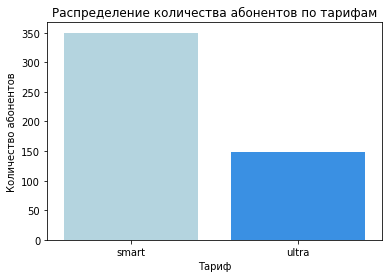

In [46]:
ax = sns.barplot(x="tariff", y= 'count', data=user_behavior.groupby(
                  'tariff', as_index=False).agg(count=('user_id', 'nunique')), palette=['lightblue', 'dodgerblue'])
ax.set_title('Распределение количества абонентов по тарифам')
ax.set(xlabel='Тариф', ylabel='Количество абонентов');

Пользователей тарифа «Смарт» ~ в два раза больше, чем тарифа «Ультра»

### Анализ звонков 

Распределение среднего количества звонков по видам тарифов и месяцам

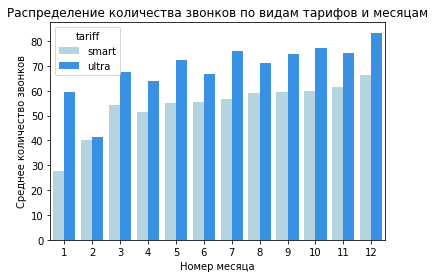

In [47]:
ax = sns.barplot(x='month',
            y='calls_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'dodgerblue'])

ax.set_title('Распределение количества звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество звонков');

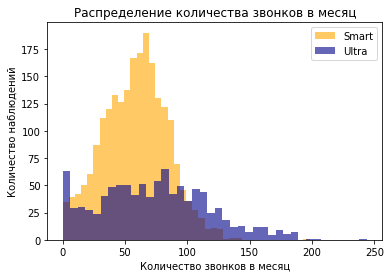

In [79]:

user_behavior[user_behavior['tariff'] =='smart']['calls'].plot(kind='hist', bins=40, color='orange', alpha=0.6)
user_behavior[user_behavior['tariff'] =='ultra']['calls'].plot(kind='hist', bins=40, color='darkblue', alpha=0.6)
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество звонков в месяц')
plt.ylabel('Количество наблюдений')
plt.title('Распределение количества звонков в месяц')
plt.show();

Распределение средней продолжительности звонков по видам тарифов и месяцам

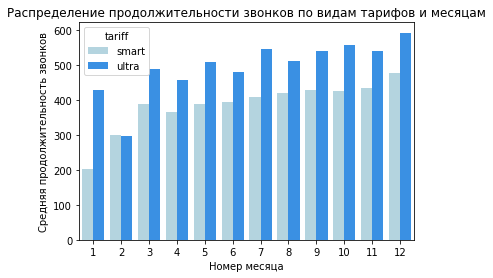

In [74]:
ax = sns.barplot(x='month',
            y='minutes_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'dodgerblue'])

ax.set_title('Распределение продолжительности звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Средняя продолжительность звонков');

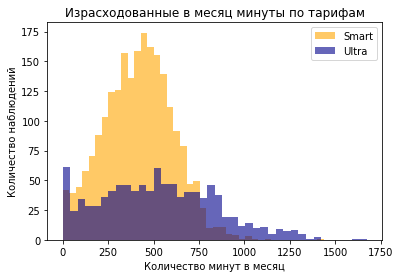

In [84]:
user_behavior[user_behavior['tariff'] =='smart']['minutes'].plot(kind='hist', bins=40, color='orange', alpha=0.6)
user_behavior[user_behavior['tariff'] =='ultra']['minutes'].plot(kind='hist', bins=40, color='darkblue', alpha=0.6)
plt.title('Израсходованные в месяц минуты по тарифам')
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество минут в месяц')
plt.ylabel('Количество наблюдений')
plt.show()

Средняя длительность разговоров и количество звонков у абонентов тарифа Ultra больше, чем у абонентов тарифа Smart.  
В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров.  
Рост средней длительности разговоров у абонентов тарифа Smart равномерный в течение года.  
Пользователи тарифа Ultra не проявляют подобной линейной стабильности.  
Стоит отметить, что феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели.

### Анализ cообщений

Распределение среднего количества сообщений по видам тарифов и месяцам

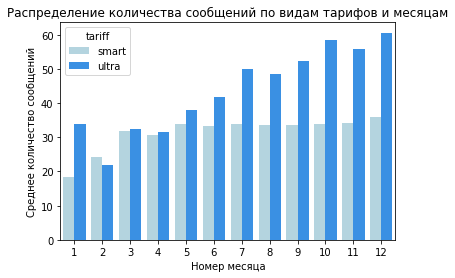

In [72]:
ax = sns.barplot(x='month',
            y='messages_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'dodgerblue']
)

ax.set_title('Распределение количества сообщений по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество сообщений');

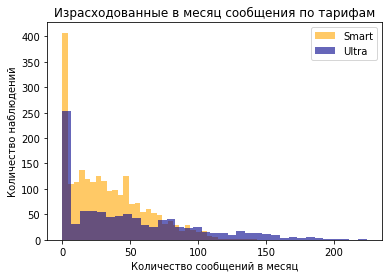

In [86]:
user_behavior[user_behavior['tariff'] =='smart']['messages'].plot(kind='hist', bins=35, color='orange', alpha=0.6)
user_behavior[user_behavior['tariff'] =='ultra']['messages'].plot(kind='hist', bins=35, color='darkblue', alpha=0.6)
plt.title('Израсходованные в месяц сообщения по тарифам')
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество сообщений в месяц')
plt.ylabel('Количество наблюдений')
plt.show();

В среднем количество сообщений пользователи тарифа Ultra отправляют больше - почти на 20 сообщений больше, чем пользователи тарифа Smart.  
Количество сообщений в течение года на обоих тарифах растет.  
Динамика по отправке сообщений схожа с тенденциями по длительности разговоров: в феврале отмечено наименьшее количество сообщений за год и пользователи тарифа Ultra также проявляют нелинейную положительную динамику.

### Анализ интернет-трафика

Распределение интернет-трафика по тарифам и месяцам

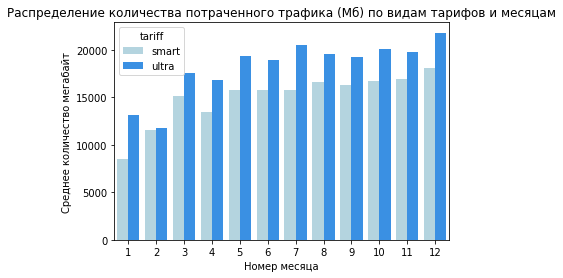

In [75]:
ax = sns.barplot(x='month',
            y='sessions_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'dodgerblue']
)

ax.set_title('Распределение количества потраченного трафика (Мб) по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество мегабайт');

Сравнение потраченных мегабайт среди пользователей тарифов Smart и Ultra

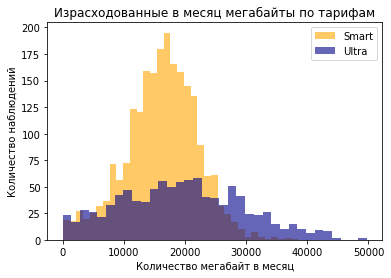

''

In [87]:

user_behavior[user_behavior['tariff'] =='smart']['mb_used'].plot(kind='hist', bins=35, color='orange', alpha=0.6)
user_behavior[user_behavior['tariff'] =='ultra']['mb_used'].plot(kind='hist', bins=35, color='darkblue', alpha=0.6)
plt.title('Израсходованные в месяц мегабайты по тарифам')
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество мегабайт в месяц')
plt.ylabel('Количество наблюдений')
plt.show()
;

Меньше всего пользователи использовали интернет в январе, феврале и апреле.  
Чаще всего абоненты тарифа Smart тратят 15-17 Гб, а абоненты тарифного плана Ultra - 19-21 ГБ.

### Анализ выручки на пользователя

Посмотрим как распределяется средняя выручка на пользователя по тарифам за год  
Сгруппируем сумму за год и разделим на количество абонентов

In [89]:
# абонентская плата по тарифам за год
monthly_fee_month = user_behavior.groupby('tariff', as_index = False).agg({'rub_monthly_fee':'sum'})
monthly_fee_month['tag'] = 'monthly_fee'

# общая выручка по тарифам за год
total_cost_per_month = user_behavior.groupby('tariff', as_index = False).agg({'total_cost':'sum'})
total_cost_per_month['tag'] = 'total'

total_cost_per_month.columns = monthly_fee_month.columns

# объединим таблицы одна под другой
revenue=pd.concat([total_cost_per_month, monthly_fee_month], ignore_index=True)
revenue.rename(columns={'rub_monthly_fee':'revenue'}, inplace=True)

# посчитаем пользователей
count_user = user_behavior.groupby('tariff', as_index=False).agg(count=('user_id', 'nunique'))

# добавим количество пользователей в таблицу с выручкой
revenue = revenue.merge(count_user, how='left', on='tariff')

# посчитаем среднюю выручку на абонента за год
revenue['revenue_per_user'] = revenue['revenue']/revenue['count']

display(revenue)
          

,tariff,revenue,tag,count,revenue_per_user
0,smart,2875351.0,total,350,8215.288571
1,ultra,2039100.0,total,148,13777.702703
2,smart,1225950.0,monthly_fee,350,3502.714286
3,ultra,1920750.0,monthly_fee,148,12978.040541


Общая выручка за год `revenue` больше у тарифа «Смарт», тк большее число абонентов, но  выручка на пользователя `revenue_per_user` больше у тарифа «Ультра»  

Визуализируем  выручку на абонента - общую и за счет абонентской платы :

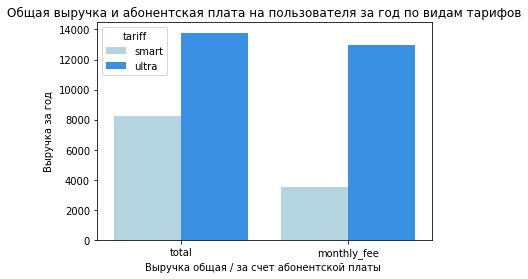

In [92]:
ax = sns.barplot(x='tag', y='revenue_per_user', hue="tariff", data=revenue, palette=['lightblue', 'dodgerblue'])

ax.set_title('Общая выручка и абонентская плата на пользователя за год по видам тарифов')
ax.set(xlabel='Выручка общая / за счет абонентской платы ', ylabel='Выручка за год');

Видим, что выручка на пользователя больше у тарифа «Ультра» и это складывается почти полностью за счет абонентской платы. Дополнительные платные услуги на тарифе «Смарт» позволили сократить разрыв, но все равно общая выручка осталась меньше  
Рассчитаем далее насколько разница статистически значима

## Проверка гипотез

Проверка гипотезы: **средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются**

```
H_0: Выручка (total_cost) пользователей "Ультра" = выручка (total_cost) пользователей "Смарт"`
H_a: Выручка (total_cost) пользователей "Ультра" ≠ выручка (total_cost) пользователей "Смарт"`
alpha = 0.05
```

In [ ]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    user_behavior[user_behavior['tariff'] =='smart']['total_cost'], 
    user_behavior[user_behavior['tariff'] =='ultra']['total_cost'],
    equal_var = False)

alpha = 0.05 #задайте значение уровня значимости

print(user_behavior[user_behavior['tariff'] =='smart']['total_cost'].mean()/user_behavior[user_behavior['tariff'] =='ultra']['total_cost'].mean()-1)

# вывод значения p-value на экран 
print(results.pvalue)
# условный оператор с выводом строки с ответом

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, обнаружены статистически значимые различия в средней выручке пользователей тарифов «Ультра» и «Смарт»")
else:
    print("Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в средней выручке пользователей тарифов «Ультра» и «Смарт» не обнаружено") 

-0.37687022325030617
4.2606313931076085e-250
Отвергаем нулевую гипотезу, обнаружены статистически значимые различия в средней выручке пользователей тарифов «Ультра» и «Смарт»


Посмотрим как различаются средние выручки между тарифами

In [ ]:
user_behavior[user_behavior['tariff'] =='ultra']['total_cost'].mean()/user_behavior[user_behavior['tariff'] =='smart']['total_cost'].mean()-1

0.6048021412427091

Средняя выручка на пользователя тарифа «Ультра» больше на 67.7% выручки тарифа «Смарт»  
В первую очередь, это связано с тем, что абонентская плата тарифа «Ультра» гораздо выше (1950 против 550)

Проверка гипотезы: **пользователи из Москвы приносят больше выручки, чем пользователи из других городов**

```
H_0: Выручка (total_cost) пользователей из Москвы = выручка (total_cost) пользователей не из Москвы`
H_1: Выручка (total_cost) пользователей из Москвы ≠ выручка (total_cost) пользователей не из Москвы`
alpha = 0.05
```

In [ ]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    user_behavior[user_behavior['city'] =='Москва']['total_cost'], 
    user_behavior[user_behavior['city'] !='Москва']['total_cost'],
    )

alpha = 0.05 #задайте значение уровня значимости

# вывод значения p-value на экран 
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, обнаружены статистически значимые различия в средней выручке между пользователями Москвы и других регионов")
else:
    print("Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в средней выручке между пользователями Москвы и других регионов не обнаружено") 

0.5440152911670224
Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в средней выручке между пользователями Москвы и других регионов не обнаружено


## Вывод

Мы проанализировали поведение 500 пользователей двух тарифных планов мобильного оператора «Мегалайн»:

 * Абонентов тарифа «Смарт» в 2 раза больше, чем у абонентов тарифа «Ультра»
 * Количество средняя длительность разговоров у абонентов тарифа «Ультра» больше, чем у абонентов тарифа «Смарт».  
 * В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. 
 * В среднем количество сообщений пользователи тарифа «Ультра» отправляют больше - почти на 20 сообщений больше, чем пользователи тарифа «Смарт».  
 * Количество сообщений в течение года на обоих тарифах растет.  
 * В феврале отмечена минимальная продолжительность звонков и  наименьшее количество звонков и сообщений за год.
 * Интернет трафик также растет в течении года, минимальный объем в январе-феврале 
 * Средняя общая выручка на пользователя тарифа «Ультра» больше на 60.5% выручки тарифа «Смарт», разница статистически значимая  
 Это связано с тем, что абонентская плата тарифа «Ультра» выше (1950 против 550), а дополнительно оплачиваемые услуги тарифа «Смарт» не позволяют достичь уровня выручки тарифа «Ультра»

 * Не обнаружено статистически значимых различий в средней выручке между пользователями Москвы и других регионов

